In [1]:
import numpy as np
from numpy import dtype
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn
from scipy import stats,signal
from datetime import date
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.stats import ttest_1samp


# Question 1

Finish reading H500


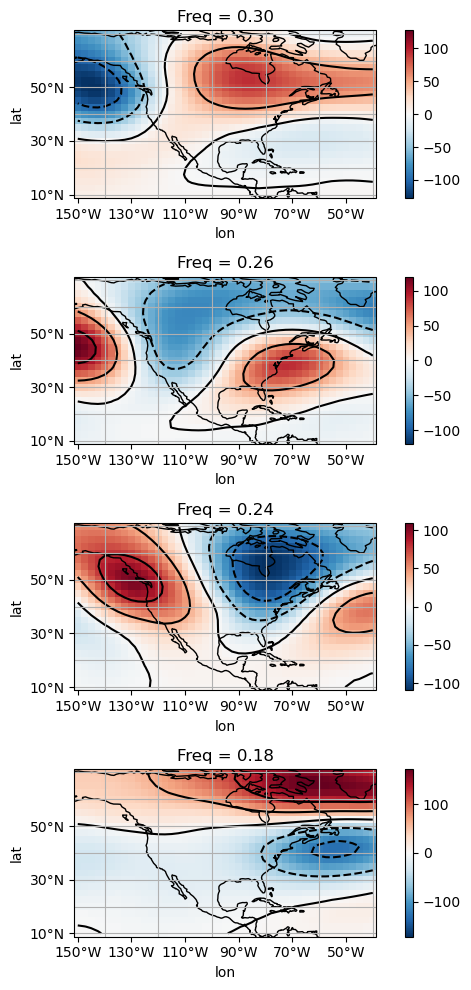

In [2]:
#define the latlon domain and the time period
lat1=10;lat2=70
lon1=210;lon2=320
lev0=500
iyr1=1979;iyr2=2020
nyr=iyr2-iyr1+1
#dtxx can be used to select a subset of data in the time dimensio
dt01='-12-01';dt02='-12-31'
dt11='-01-01';dt12='-02-28'	#neglect leap years
ndy=(date(1980,2,28)-date(1979,12,1)).days+1

#number of weather regimes
nclusters=4

#input file info
dir='/data/zhuowang/b/zhuowang/Data/NNR2/daily/hgt.'
hgt = xr.DataArray(np.zeros((nyr, ndy,len(np.arange(lat1,lat2+1, 2.5)) , len(np.arange(lon1, lon2+1, 2.5)))), dims=('year', 'day', 'lat', 'lon'),
                   coords={'year': np.arange(iyr1, iyr2+1), 'day': np.arange(1, ndy+1),
                           'lat': np.arange(lat1,lat2+1, 2.5), 'lon': np.arange(lon1, lon2+1, 2.5)})
"""
Read daily H500 during Dec-Feb from 1979-2020. 
Note that the latitude dimension is reversed!
"""
for iyr in range(iyr1,iyr2+1):
   #read Dec in Year(0) into hgt0
    df = xr.open_mfdataset(dir+str(iyr)+'.nc')
    hgt0 = df['hgt'].sel(level=500, time=slice(str(iyr)+dt01,str(iyr)+dt02), lat=slice(lat1,lat2,-1), lon=slice(lon1,lon2 ))
    #read Jan and Feb in Year(+1) into hgt1
    df = xr.open_mfdataset(dir+str(iyr+1)+'.nc')
    hgt1 = df['hgt'].sel(level=500, time=slice(str(iyr+1)+dt11,str(iyr+1)+dt12), lat=slice(lat1,lat2,-1), lon=slice(lon1,lon2 ))
   #concatenate Dec data and Jan-Feb data. hgt01 is of the shape [nyr, ndy, nlat, nlon]
    hgt01=xr.concat([hgt0,hgt1],dim='time') 
    #take the 5-day running mean using "rolling" and save the output in the array hgt
    #hgt is of the shape [nyr, ndy, nlat, nlon]
    hgt[iyr-iyr1,:,:,:]=hgt01.rolling(time=5, center=True,min_periods=3).mean().values
print('Finish reading H500')


#remove the seasonal cycle (the long-term mean on each calendar day) 
hgt = hgt-hgt.groupby('day').mean(dim='year')


#remove the linear trend
# compute the linear trend for each grid point time series
trend = hgt.polyfit(dim='year', deg=1)

# subtract the linear trend from the data

hgt = hgt - trend.polyfit_coefficients.sel(degree=1)*hgt['year']-trend.polyfit_coefficients.sel(degree=0)


lons = np.arange(lon1, lon2+1, 2.5)
lats = np.arange(lat1, lat2+1,2.5)
nlat = len(lats)
nlon = len(lons)

#calculate a cosine weighting function
lon2d,lat2d=np.meshgrid(lons,lats)
wgt=np.cos(lat2d*np.pi/180.0)
wgts=np.repeat(wgt[np.newaxis,:],nyr*ndy,axis=0)   
wgts=np.reshape(wgts,(nyr*ndy,nlat*nlon))
# reshape the data to 2D array for clustering
hgt_stacked = hgt.stack(time=['year', 'day']).transpose('time', 'lat', 'lon')
# perform K-means clustering with the cosine weights
kmeans = KMeans(n_clusters=4)
X = np.reshape(hgt_stacked.values, (len(hgt_stacked.time), -1))
X=X*wgts #cosine-weighted H500
labels = kmeans.fit_predict(X)
labels = xr.DataArray(labels, dims=['time'], coords={'time': hgt_stacked.time})

freq = labels.groupby(labels).count(dim='time') / len(labels)
inx = np.argsort(-freq.values)

fig, axs = plt.subplots(4, figsize=(6, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_n = 0
for i in inx:
    composite = hgt_stacked.sel(time=labels==i).mean(dim='time')
    # plot the composite mean using matplotlib or other plotting libraries
#     composite.plot(ax = axs[plot_n],vmin = -150, vmax = 200 , cmap = 'RdBu')
    composite.plot(ax = axs[plot_n])
    composite.plot.contour(ax = axs[plot_n], colors='black')
    axs[plot_n].set_title("Freq = "+ str(freq.values[i])[:4])
    axs[plot_n].coastlines()
    axs[plot_n].gridlines()
    xticks = range(-150, -40, 20)
    yticks = range(10, 70, 20)
    axs[plot_n].set_xticks(xticks, crs=ccrs.PlateCarree())
    axs[plot_n].set_yticks(yticks, crs=ccrs.PlateCarree())
    # set the latitude and longitude tick labels
    axs[plot_n].xaxis.set_major_formatter(cticker.LongitudeFormatter())
    axs[plot_n].yaxis.set_major_formatter(cticker.LatitudeFormatter())
    plot_n = plot_n+1
# add tight layout to the figure
plt.tight_layout()
plt.show()


# Question 2

Finish reading precip


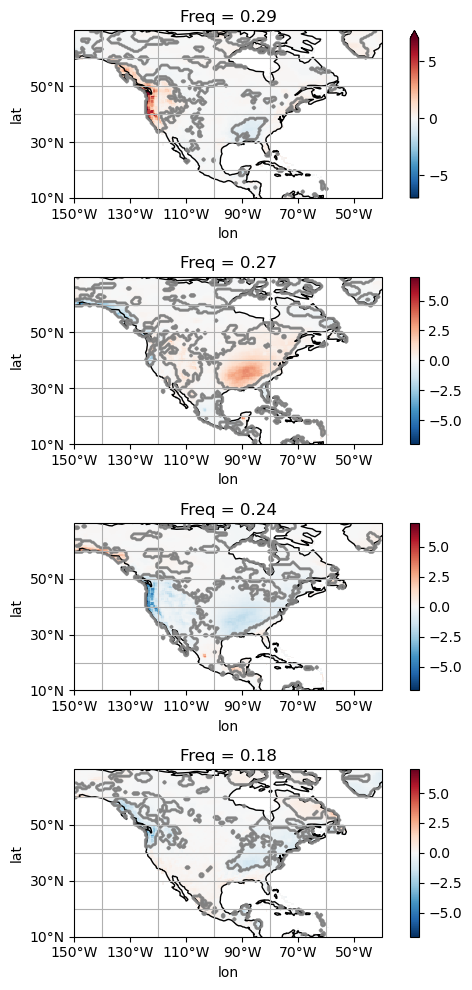

In [3]:
#input file info
dir='/data/zhuowang/b/zhuowang/Data/CPC_Global/precip.'
precip = xr.DataArray(np.zeros((nyr, ndy,len(np.arange(10.25,69.76, 0.5)) , len(np.arange(210.25, 319.76, 0.5)))), dims=('year', 'day', 'lat', 'lon'),
                   coords={'year': np.arange(iyr1, iyr2+1), 'day': np.arange(1, ndy+1),
                           'lat': np.arange(10.25,69.76, 0.5), 'lon': np.arange(210.25, 319.76, 0.5)})
"""
Read daily precip data during Dec-Feb from 1979-2020. 
"""
for iyr in range(iyr1,iyr2+1):
   #read Dec in Year(0) into hgt0
    df = xr.open_mfdataset(dir+str(iyr)+'.nc')
    precip0 = df['precip'].sel( time=slice(str(iyr)+dt01,str(iyr)+dt02), lat=slice(lat1,lat2,-1), lon=slice(lon1,lon2 ))
    #read Jan and Feb in Year(+1) into hgt1
    df = xr.open_mfdataset(dir+str(iyr+1)+'.nc')
    precip1 = df['precip'].sel( time=slice(str(iyr+1)+dt11,str(iyr+1)+dt12), lat=slice(lat1,lat2,-1), lon=slice(lon1,lon2 ))
   #concatenate Dec data and Jan-Feb data. hgt01 is of the shape [nyr, ndy, nlat, nlon]
    precip01=xr.concat([precip0,precip1],dim='time') 
    
    precip[iyr-iyr1,:,:,:]=precip01.values
print('Finish reading precip')


#Calculate daily anomalies by removing the seasonal cycle
precip = precip-precip.groupby('day').mean(dim='year')
precip_stacked = precip.stack(time=['year', 'day']).transpose('time', 'lat', 'lon')


fig, axs = plt.subplots(4, figsize=(6, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_n = 0
for i in inx:
    composite = precip_stacked.sel(time=labels==i)
    composite_mean = composite.mean(dim='time')
    tstat, pval = ttest_1samp(composite, 0.0, nan_policy='omit')
    sig_mask = np.where(pval < 0.01, 1, 0)
    sig = xr.DataArray(data=sig_mask, dims=["lat", "lon"], coords=[composite_mean.lat,composite_mean.lon])
    composite_mean.plot(ax = axs[plot_n],vmin = -7, vmax = 7 ,cmap = "RdBu_r")
    sig.plot.contour(ax = axs[plot_n], colors='grey', alpha = 0.5)
    axs[plot_n].set_title("Freq = "+ str(freq.values[i])[:4])
    axs[plot_n].coastlines()
    axs[plot_n].gridlines()
    xticks = range(-150, -40, 20)
    yticks = range(10, 70, 20)
    axs[plot_n].set_xticks(xticks, crs=ccrs.PlateCarree())
    axs[plot_n].set_yticks(yticks, crs=ccrs.PlateCarree())
    # set the latitude and longitude tick labels
    axs[plot_n].xaxis.set_major_formatter(cticker.LongitudeFormatter())
    axs[plot_n].yaxis.set_major_formatter(cticker.LatitudeFormatter())
    plot_n = plot_n+1
# add tight layout to the figure
plt.tight_layout()
plt.show()


# Question 3


Finish reading temperature


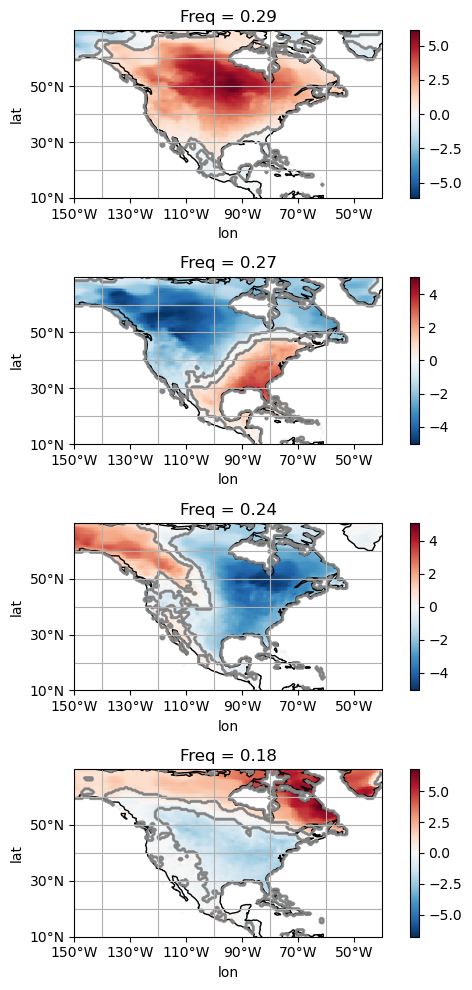

In [4]:
#input file info
dir='/data/zhuowang/b/zhuowang/Data/CPC_Global/tmin.'
tmin = xr.DataArray(np.zeros((nyr, ndy,len(np.arange(10.25,69.76, 0.5)) , len(np.arange(210.25, 319.76, 0.5)))), dims=('year', 'day', 'lat', 'lon'),
                   coords={'year': np.arange(iyr1, iyr2+1), 'day': np.arange(1, ndy+1),
                           'lat': np.arange(10.25,69.76, 0.5), 'lon': np.arange(210.25, 319.76, 0.5)})
"""
Read daily precip data during Dec-Feb from 1979-2020. 
"""
for iyr in range(iyr1,iyr2+1):
   #read Dec in Year(0) into hgt0
    df = xr.open_mfdataset(dir+str(iyr)+'.nc')
    tmin0 = df['tmin'].sel( time=slice(str(iyr)+dt01,str(iyr)+dt02), lat=slice(lat1,lat2,-1), lon=slice(lon1,lon2 ))
    #read Jan and Feb in Year(+1) into hgt1
    df = xr.open_mfdataset(dir+str(iyr+1)+'.nc')
    tmin1 = df['tmin'].sel( time=slice(str(iyr+1)+dt11,str(iyr+1)+dt12), lat=slice(lat1,lat2,-1), lon=slice(lon1,lon2 ))
   #concatenate Dec data and Jan-Feb data. hgt01 is of the shape [nyr, ndy, nlat, nlon]
    tmin01=xr.concat([tmin0,tmin1],dim='time') 
    
    tmin[iyr-iyr1,:,:,:]=tmin01.values
print('Finish reading temperature')


#Calculate daily anomalies by removing the seasonal cycle
tmin = tmin-tmin.groupby('day').mean(dim='year')
tmin_stacked = tmin.stack(time=['year', 'day']).transpose('time', 'lat', 'lon')


fig, axs = plt.subplots(4, figsize=(6, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_n = 0
for i in inx:
    composite = tmin_stacked.sel(time=labels==i)
    composite_mean = composite.mean(dim='time')
    tstat, pval = ttest_1samp(composite, 0.0, nan_policy='omit')
    sig_mask = np.where(pval < 0.01, 1, 0)
    sig = xr.DataArray(data=sig_mask, dims=["lat", "lon"], coords=[composite_mean.lat,composite_mean.lon])
    composite_mean.plot(ax = axs[plot_n])
    sig.plot.contour(ax = axs[plot_n], colors='grey', alpha = 0.5)
    axs[plot_n].set_title("Freq = "+ str(freq.values[i])[:4])
    axs[plot_n].coastlines()
    axs[plot_n].gridlines()
    xticks = range(-150, -40, 20)
    yticks = range(10, 70, 20)
    axs[plot_n].set_xticks(xticks, crs=ccrs.PlateCarree())
    axs[plot_n].set_yticks(yticks, crs=ccrs.PlateCarree())
    # set the latitude and longitude tick labels
    axs[plot_n].xaxis.set_major_formatter(cticker.LongitudeFormatter())
    axs[plot_n].yaxis.set_major_formatter(cticker.LatitudeFormatter())
    plot_n = plot_n+1
# add tight layout to the figure
plt.tight_layout()
plt.show()


# Question 4

In [5]:
# read the monthly mean SPI data at the three-month scale
spi_path = '/data/zhuowang/b/zhuowang/Data/SPI/spi3_6_12_1deg_cru_ts_3_21_1949_2012.nc'
spi_data = xr.open_dataset(spi_path)['spi3']
spi_data = spi_data.sel(lat=slice(32, 45), lon=slice(-105, -85),time=spi_data['time.season']=='JJA')
spi_data = spi_data.sel(time = slice('1979', '2012'))
spi_jja_mean = spi_data.mean(dim=['lat', 'lon'])


## Load H500 data and calculate monthly anomalies
hgt_path = '/data/zhuowang/b/shared/NNR2/monthly/hgt.mon.mean.nc'
hgt_data = xr.open_dataset(hgt_path)['hgt']
hgt_data = hgt_data.sel(level = 500, lat=slice(10, 70, -1), lon=slice(210, 320),time=hgt_data['time.season']=='JJA')
hgt_data = hgt_data.sel(time = slice('1979', '2012'))
hgt_clim = hgt_data.groupby('time.month').mean(dim='time')
hgt_anom = hgt_data.groupby('time.month') - hgt_clim


## Load soil moisture data and calculate monthly anomalies
soilw_path = '/data/zhuowang/b/shared/NNR2/monthly/soilw.0-10cm.mon.mean.nc'
soilw_data = xr.open_dataset(soilw_path)['soilw']
soilw_data = soilw_data.sel(level = 0, lat=slice(10, 70, -1), lon=slice(210, 320),time=soilw_data['time.season']=='JJA')
soilw_data = soilw_data.sel(time = slice('1979', '2012'))
soilw_clim = soilw_data.groupby('time.month').mean(dim='time')
soilw_anom = soilw_data.groupby('time.month') - soilw_clim

/data/keeling/a/junrenw2/miniconda3/envs/atm521/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'hgt' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


When the threshold SPI <=-0.75 is used, the sample size is 10
When the threshold SPI <=-1.0 is used, the sample size is 4


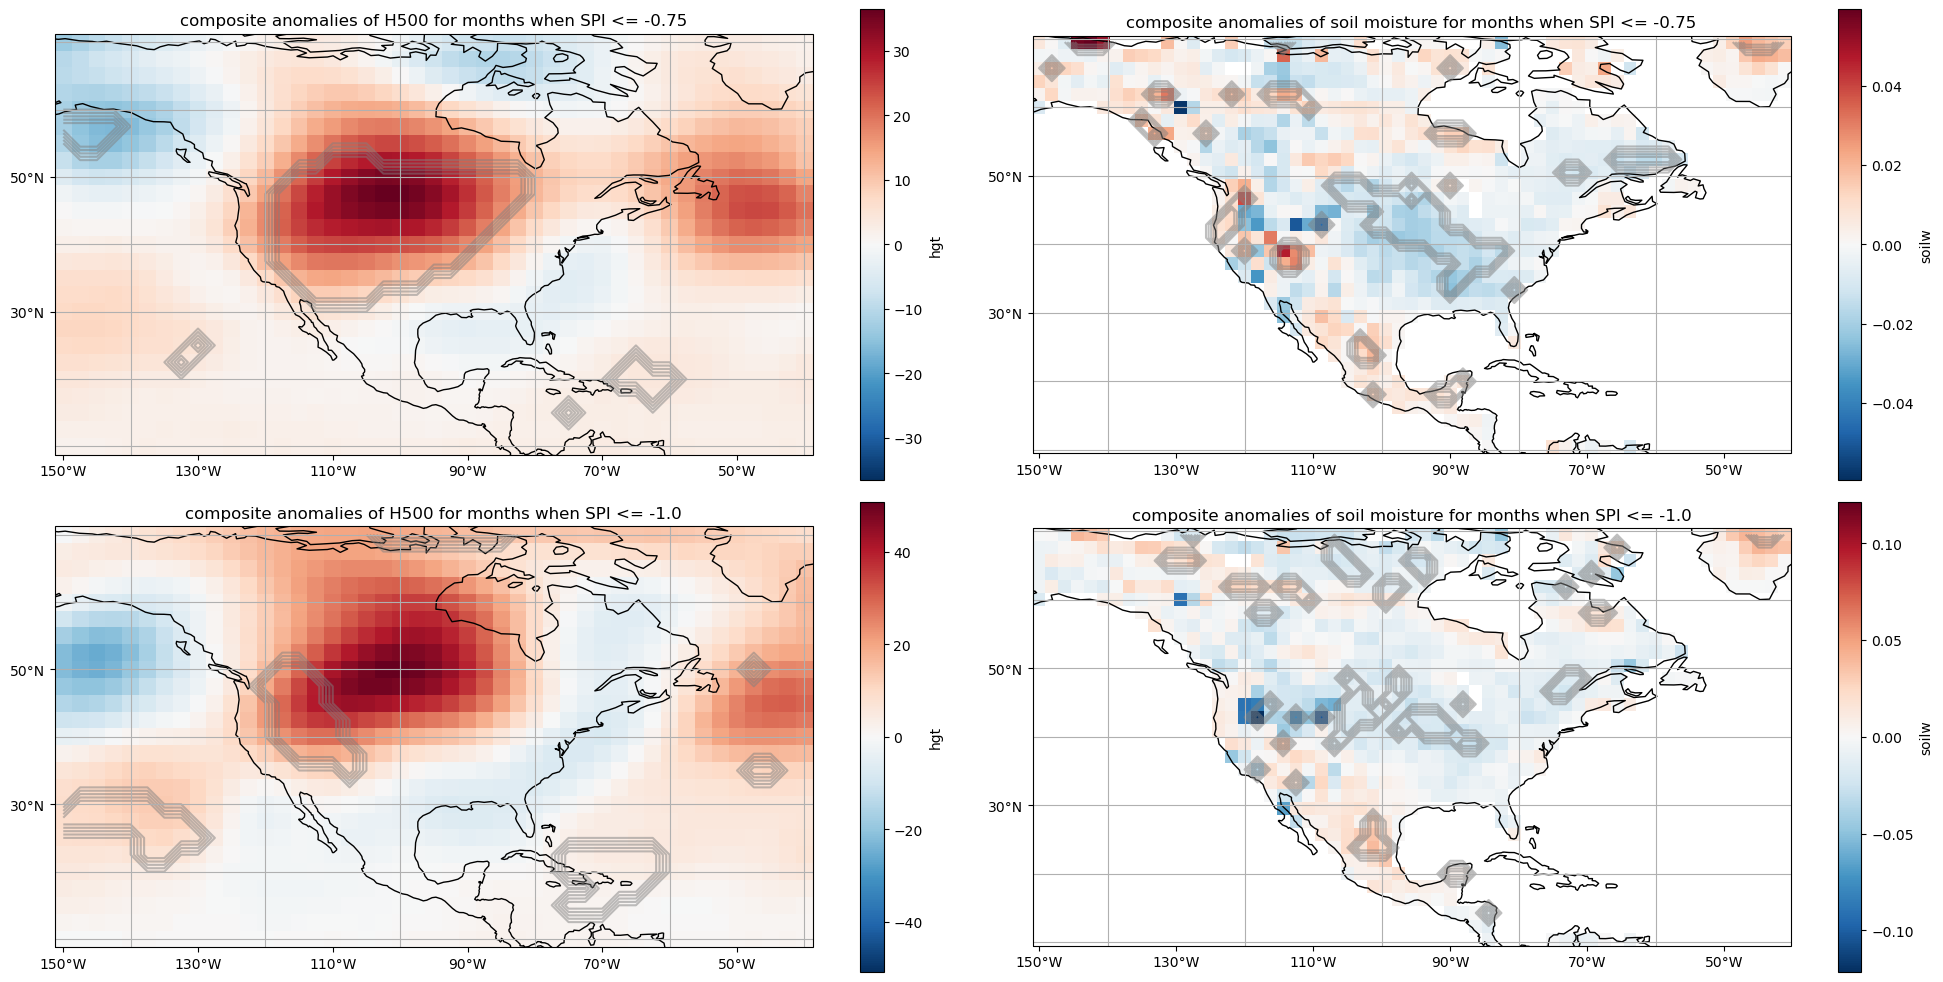

In [6]:
fig, axs = plt.subplots(2,2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# Calculate composite anomalies of H500 for SPI<=-0.75
spi_thresh = -0.75
spi_bool = spi_jja_mean <= spi_thresh
print("When the threshold SPI <=-0.75 is used, the sample size is "+str(sum(spi_bool.values)))
hgt_comp = hgt_anom.sel(time = hgt_anom['time'][spi_bool.values]).mean(dim='time')
soilw_comp = soilw_anom.sel(time = soilw_anom['time'][spi_bool.values]).mean(dim='time')
hgt_comp.plot( cmap='RdBu_r', ax = axs[0, 0])
tstat, pval = ttest_1samp(hgt_anom.sel(time = hgt_anom['time'][spi_bool.values]), 0.0, nan_policy='omit')
sig_mask = np.where(pval < 0.05, 1, 0)
sig = xr.DataArray(data=sig_mask, dims=["lat", "lon"], coords=[hgt_comp.lat,hgt_comp.lon])
sig.plot.contour(ax = axs[0, 0], colors='grey', alpha = 0.5)
axs[0, 0].set_title("composite anomalies of H500 for months when SPI <= -0.75")

soilw_comp.plot( cmap='RdBu_r', ax = axs[0, 1])
tstat, pval = ttest_1samp(soilw_anom.sel(time = soilw_anom['time'][spi_bool.values]), 0.0, nan_policy='omit')
sig_mask = np.where(pval < 0.05, 1, 0)
sig = xr.DataArray(data=sig_mask, dims=["lat", "lon"], coords=[soilw_comp.lat,soilw_comp.lon])
sig.plot.contour(ax = axs[0, 1], colors='grey', alpha = 0.5)
axs[0, 1].set_title("composite anomalies of soil moisture for months when SPI <= -0.75")

spi_thresh = -1.0
spi_bool = spi_jja_mean <= spi_thresh
print("When the threshold SPI <=-1.0 is used, the sample size is "+str(sum(spi_bool.values)))
hgt_comp = hgt_anom.sel(time = hgt_anom['time'][spi_bool.values]).mean(dim='time')
soilw_comp = soilw_anom.sel(time = soilw_anom['time'][spi_bool.values]).mean(dim='time')

hgt_comp.plot( cmap='RdBu_r', ax = axs[1, 0])

tstat, pval = ttest_1samp(hgt_anom.sel(time = hgt_anom['time'][spi_bool.values]), 0.0, nan_policy='omit')
sig_mask = np.where(pval < 0.05, 1, 0)
sig = xr.DataArray(data=sig_mask, dims=["lat", "lon"], coords=[hgt_comp.lat,hgt_comp.lon])
sig.plot.contour(ax = axs[1, 0], colors='grey', alpha = 0.5)
axs[1, 0].set_title("composite anomalies of H500 for months when SPI <= -1.0")

soilw_comp.plot( cmap='RdBu_r', ax = axs[1, 1])
tstat, pval = ttest_1samp(soilw_anom.sel(time = soilw_anom['time'][spi_bool.values]), 0.0, nan_policy='omit')
sig_mask = np.where(pval < 0.05, 1, 0)
sig = xr.DataArray(data=sig_mask, dims=["lat", "lon"], coords=[soilw_comp.lat,soilw_comp.lon])
sig.plot.contour(ax = axs[1, 1], colors='grey', alpha = 0.5)
axs[1, 1].set_title("composite anomalies of soil moisture for months when SPI <= -1.0")

for ax in  axs.flat: 
    ax.coastlines()
    ax.gridlines()
    xticks = range(-150, -40, 20)
    yticks = range(30, 70, 20)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    # set the latitude and longitude tick labels
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.set_xlabel("")
    ax.set_ylabel("")
# add tight layout to the figure
plt.tight_layout()

The atmospheric circulation and soil moisture anomalies are closely linked to the drought conditions over the Great Plains.

When the SPI index is below a certain threshold (i.e. SPI <= -0.75 or SPI <= -1.0), it is an indication of drought conditions. It appears that the composite anomalies of H500 show a blocking high, which can lead to reduced precipitation and contribute to drought conditions over the Great Plains. The low soil moisture, which is also evident in the composite anomalies, can exacerbate drought conditions by reducing the evapotranspiration. 